In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.forecasting.theta               import ThetaForecaster
from sktime.forecasting.fbprophet           import Prophet
from sktime.forecasting.base                import ForecastingHorizon

from sklearn                import preprocessing 
from sklearn.metrics        import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.linear_model   import Lasso

from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster,TrendForecaster
from sktime.forecasting.exp_smoothing       import ExponentialSmoothing
from sktime.forecasting.statsforecast       import StatsForecastAutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag      import Lag


from sktime.forecasting.compose import AutoEnsembleForecaster
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import RecursiveTabularRegressionForecaster
from sktime.transformations.compose import YtoX, Id, FeatureUnion
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.date import DateTimeFeatures
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.compose import make_reduction

from sktime.datasets import load_airline
import warnings


### Pipelining doesn't work with the multiplication thing. The forecasting model is not built correctly.

{'forecaster': RecursiveTabularRegressionForecaster(estimator=Ridge(), pooling='global',
                                      window_length=12),
 'steps': [('FeatureUnion',
   FeatureUnion(transformer_list=[Id(), DateTimeFeatures(ts_freq='M'),
                                  Differencer(lags=[1]), Lag(lags=[1, 2])])),
  ('RecursiveTabularRegressionForecaster',
   RecursiveTabularRegressionForecaster(estimator=Ridge(), window_length=12))],
 'FeatureUnion': FeatureUnion(transformer_list=[Id(), DateTimeFeatures(ts_freq='M'),
                                Differencer(lags=[1]), Lag(lags=[1, 2])]),
 'RecursiveTabularRegressionForecaster': RecursiveTabularRegressionForecaster(estimator=Ridge(), window_length=12),
 'FeatureUnion__transformer_list': [('Id', Id()),
  ('DateTimeFeatures', DateTimeFeatures(ts_freq='M')),
  ('Differencer', Differencer(lags=[1])),
  ('Lag', Lag(lags=[1, 2]))],
 'FeatureUnion__Id': Id(),
 'FeatureUnion__DateTimeFeatures': DateTimeFeatures(ts_freq='M'),
 'Featur

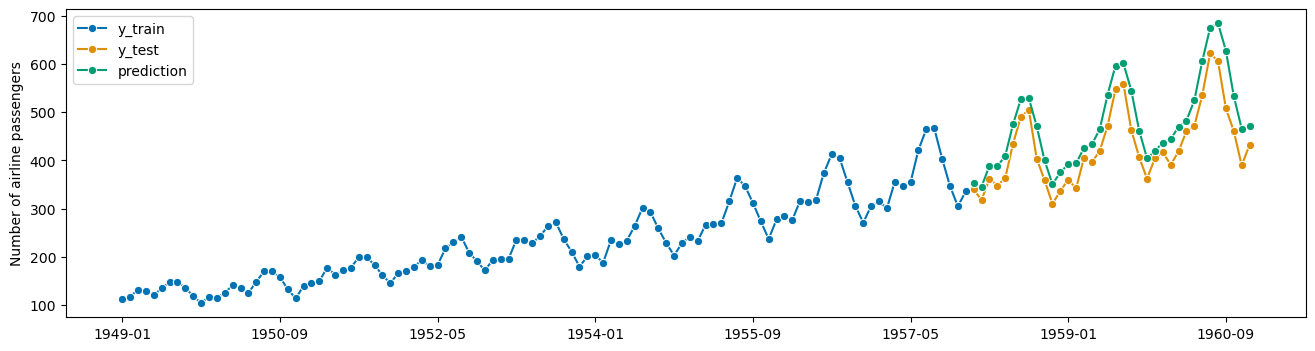

In [71]:
#ignore warnings
warnings.filterwarnings("ignore")

y = load_airline()

y_train, y_test = temporal_train_test_split(y)
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = make_reduction(Ridge(), window_length=12, strategy="recursive", pooling="global")

pipeline = (Id()
            +DateTimeFeatures(ts_freq="M", feature_scope="minimal") #IxToX()
            +Differencer([1])
            +Lag([1,2])
            )** forecaster

# pipeline = (Id()+Lag([1])+Differencer([1]))** forecaster

pipeline.fit(y=y_train)

y_pred = pipeline.predict(fh=fh)
plot_series(y_train,y_test,y_pred,labels=["y_train","y_test","prediction"])

#pipeline.get_fitted_params() --> shows only 12 fit parameters for the Ridge() estimator
pipeline.get_fitted_params()

### Transformation pipelines work on their own but not with a make_reduction forecaster.

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

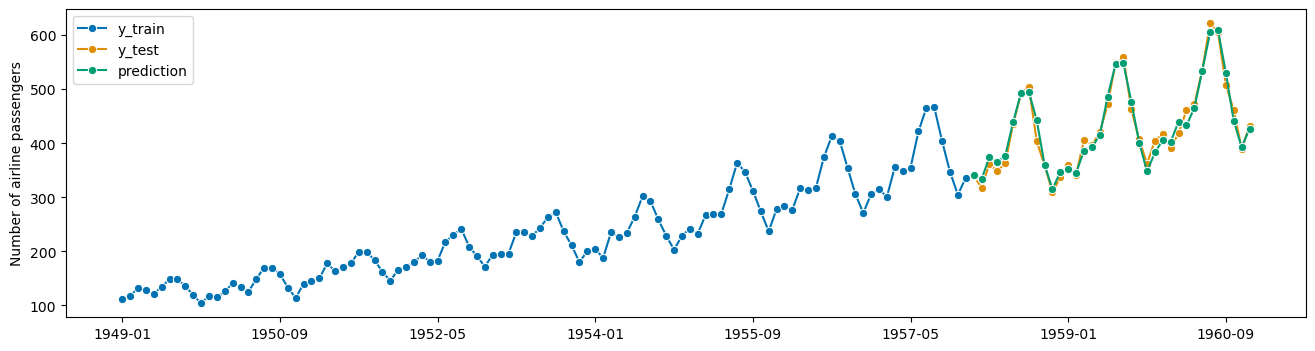

In [72]:
pipeline = (Id()
            +DateTimeFeatures(ts_freq="M", feature_scope="minimal")
            +Differencer([1])
            +Lag([1,2])
            )

# pipeline = (Id()+Lag([1,2])+Differencer([1]))

transformed = pipeline.fit_transform(y_train).dropna()
y_train_transformed = transformed["Id__Number of airline passengers"]
x_train_transformed = transformed.drop(columns="Id__Number of airline passengers")

x_test_transformed = pipeline.transform(y_test).drop(columns="Id__Number of airline passengers").dropna()

forecaster = make_reduction(Ridge(), window_length=12, strategy="recursive")
forecaster.fit(y=y_train_transformed, X=x_train_transformed)

y_pred = forecaster.predict(fh=fh, X=x_test_transformed) #DATALEAKAGE !!!!This step is not valid
plot_series(y_train,y_test,y_pred,labels=["y_train","y_test","prediction"])

In [73]:
forecaster.get_fitted_params()

{'estimator': Ridge(),
 'transformers': None,
 'window_length': 12,
 'estimator__coef': array([ 8.20615650e-02,  5.84622459e-02, -1.80180124e-02,  1.55484987e-02,
        -2.70969753e-03, -1.38420336e-02, -6.03589468e-04,  1.51226746e-02,
        -1.70242262e-02,  1.94161339e-04,  8.82612329e-02,  2.59509276e-01,
         8.20615652e-02,  5.84622459e-02, -1.80180124e-02,  1.55484988e-02,
        -2.70969755e-03, -1.38420336e-02, -6.03589485e-04,  1.51226746e-02,
        -1.70242262e-02,  1.94161348e-04,  8.82612330e-02,  2.59509276e-01,
         3.07070285e-01,  4.57988468e-01,  2.98154016e-01,  4.70403310e-01,
         2.52924284e-01,  2.73084411e-01,  3.79719584e-01,  4.45888203e-01,
         3.41587018e-01,  2.55908733e-01,  5.19712909e-01,  2.49664588e-01,
         5.67262386e-01, -1.24375581e+00,  6.74257620e-01, -1.39273391e+00,
         1.21701440e+00,  9.75092876e-01, -3.04529200e-01, -1.09855262e+00,
         1.53061597e-01,  1.18120101e+00, -1.98444910e+00,  1.25613075e+00,
 

### But if you build them yourself you have to deal with the forecasting problem and the construction of X. 

In [74]:
from sktime.forecasting.compose import make_reduction
from sktime.datasets import load_longley
from sklearn.ensemble import GradientBoostingRegressor
from sktime.forecasting.model_selection import temporal_train_test_split

y, X = load_longley()
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

forecaster = make_reduction(Ridge(), window_length=2, strategy="recursive")
forecaster.fit(y_train, X_train[["ARMED",  "GNPDEFL", "GNP"]]) #--> model scaling seems correct. n_x_features*window_length
forecaster.get_fitted_params()

{'estimator': Ridge(),
 'transformers': None,
 'window_length': 2,
 'estimator__coef': array([-2.57651031e+00, -9.87257413e-01, -2.94919436e-01, -1.15523229e+00,
        -4.33100727e+02,  1.64201194e+02,  1.98675578e-01,  2.43565265e-02]),
 'estimator__intercept': 246464.72022744815,
 'estimator__n_features_in': 8,
 'estimator__n_iter': None}

In [75]:
X_train.columns

Index(['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP'], dtype='object')

In [6]:
import numpy as np
import pandas as pd
from sktime.forecasting.compose import make_reduction
from sktime.datasets import load_longley
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.linear_model import Ridge


y, X = load_longley()
X = X[["GNPDEFL"]]
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

forecaster = make_reduction(Ridge(), window_length=1, strategy="recursive")
forecaster.fit(y_train, X_train)

params = forecaster.get_fitted_params()
weights = params["estimator__coef"]
intercept = params['estimator__intercept']

print("----Testing a single prediction point at 1959----")
print(f"Computation by sktime: {forecaster.predict(X=X_test[0:], fh=[1])}")
print("Computation by hand as y_1959 = w1*y_1958 + w2*x_1958 + intercept")
print(np.sum(y_train[-1]*weights[0]+X_train[-1:].values*weights[1], axis =1) + intercept)

print("----Checking if the forecast changes if X changes.----")
print(forecaster.predict(X=X_test, fh=[1,2,3,4]))

df_test = pd.DataFrame({'GNPDEFL': np.random.rand(len(X_test))}, index=X_test.index)
print(forecaster.predict(X=df_test, fh=np.arange(len(df_test),dtype=int)+1))


----Testing a single prediction point at 1959----
Computation by sktime: 1959    67790.04491
Freq: A-DEC, dtype: float64
Computation by hand as y_1959 = w1*y_1958 + w2*x_1958 + intercept
[67790.04491023]
 
----Checking if the forecast changes if X changes.----
1959    67790.044910
1960    68626.445317
1961    69240.603386
1962    69742.809213
Freq: A-DEC, dtype: float64
1959    67790.044910
1960    50918.434935
1961    43706.660973
1962    40552.044450
Freq: A-DEC, dtype: float64


Summary: In this example it looks like the model is built correctly but how the forecasting works is a bit of black magic. 

When given just X 4 data points ahead of the current, it somehow fills in the missing X. 
Later giving it another X for the missing could be an interesting test. 

But the problem does not seem too related to the problem disgussed in the meeting. The model is built correctly and also works correctly. 

The model works correctly. The double check by hand verfies it. --> Put on github to the https://github.com/sktime/sktime/issues/5127.